# Data Preprocessing
  - Cleaning
  - Tokenization
  - Stop Words Removal
  - Lemmatization
  - Stemming

### Changing Directory


In [1]:
import os
import pandas as pd


current_dir = os.getcwd()
current_dir

'/workspaces/pp5-house-price-prediction/notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory") 

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/pp5-house-price-prediction'

In [4]:
df = pd.read_csv('data/processed/cleaned_corr_data.csv')
df.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt,YearRemodAdd,KitchenQual,GarageFinish,SalePrice
0,7,1710,548,856,2003,2003,3,2,208500
1,6,1262,460,1262,1976,1976,2,2,181500
2,7,1786,608,920,2001,2002,3,2,223500
3,7,1717,642,756,1915,1970,3,1,140000
4,8,2198,836,1145,2000,2000,3,2,250000


In [6]:
# To make sure my data is loaded correctly without outliers as I can see raws are correct
df.shape


(1448, 9)

## Modeling

### Split Features and Target


In [7]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Evaluation

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Linear Regression Results:")
print(f"R2 Score: {r2_score(y_test, y_pred_lr)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr))}")

print("\nRandom Forest Results:")
print(f"R2 Score: {r2_score(y_test, y_pred_rf)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")

Linear Regression Results:
R2 Score: 0.7974288920953008
RMSE: 26583.860934008117

Random Forest Results:
R2 Score: 0.8030940657156498
RMSE: 26209.498263231995


**Random Forest is slightly better based on both higher R² and lower RMSE.**

In [11]:
import matplotlib.pyplot as plt
import numpy as np

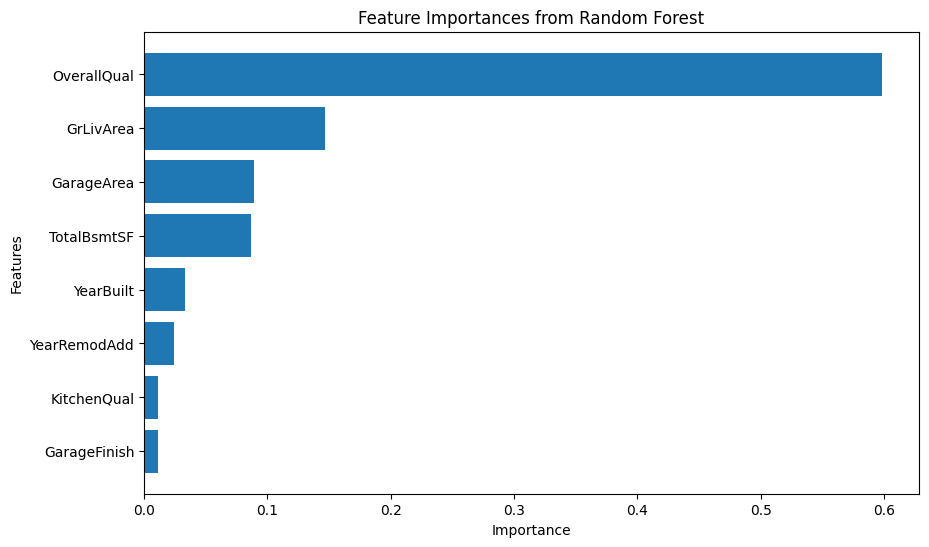

In [12]:
# Get feature importances
importances = rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

This shows which features drive the house price prediction the most — super useful for insights.

**Hyperparameter Tuning**

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup Randomized Search
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit random search
rf_random.fit(X_train, y_train)

# Best model
best_rf_model = rf_random.best_estimator_

# Predict and evaluate again
y_pred_best_rf = best_rf_model.predict(X_test)
print(f"New R2 Score: {r2_score(y_test, y_pred_best_rf)}")
print(f"New RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best_rf))}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.9s
[CV] END max_depth=20

  - R² increased → Model explains more variance.
  - RMSE decreased → Predictions are closer to real SalePrices.

In [15]:
from sklearn.model_selection import cross_val_score

# Cross-validate Random Forest
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean R2: {cv_scores.mean()}")

Cross-validated R2 scores: [0.82578556 0.86824679 0.85380257 0.86454469 0.80623913]
Mean R2: 0.8437237498372022


The model generalizes very well across different subsets of the data.

All folds have high R² (all above 0.80), no major drops — this means no overfitting and no underfitting.

Mean R² (0.843) is even better than the single holdout R² (~0.810) you saw earlier.
(Cross-validation often gives a more reliable estimate.)

## Save our model

In [17]:
import joblib

joblib.dump(best_rf_model, 'models/random_forest_best_model.pkl')

['models/random_forest_best_model.pkl']

## Plot Actual vs Predicted & Assess Performance

Train R²: 0.952
Test R²: 0.808


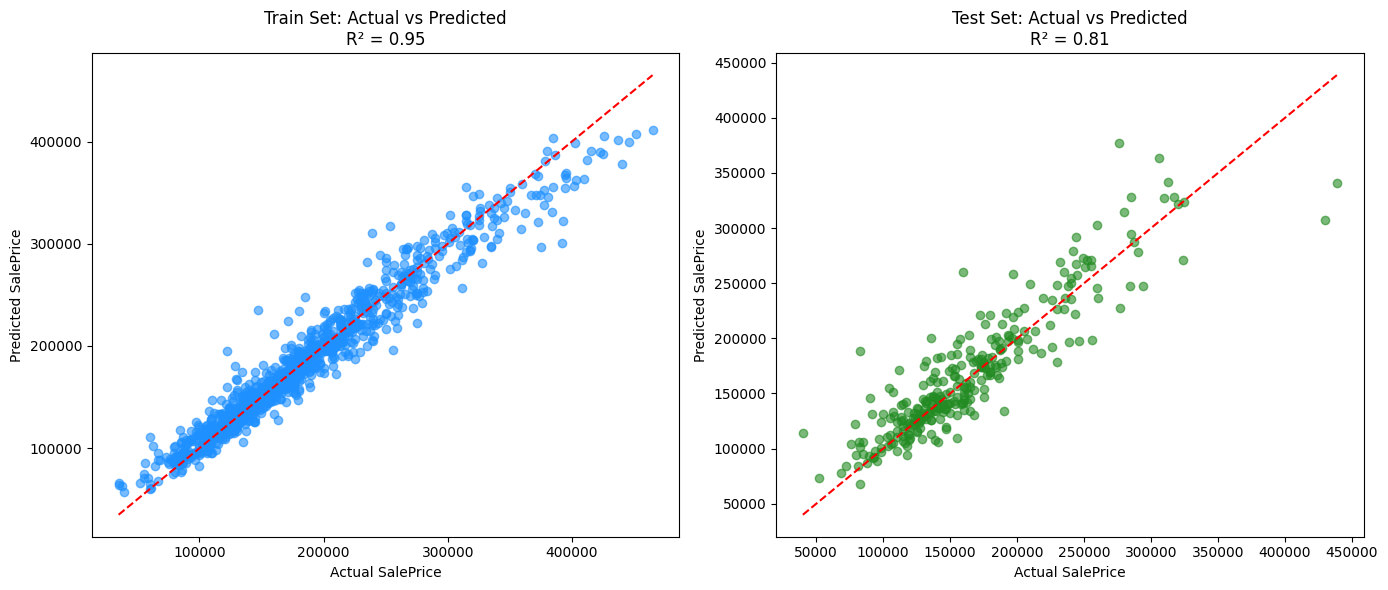


✅ The model meets the business requirement with an R² ≥ 0.80 on the test set.


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import joblib


model = joblib.load("models/random_forest_best_model.pkl")

# Prepare features and target
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train R²: {r2_train:.3f}")
print(f"Test R²: {r2_test:.3f}")

# Plotting Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_train, y_train_pred, alpha=0.6, color='dodgerblue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
axes[0].set_title(f"Train Set: Actual vs Predicted\nR² = {r2_train:.2f}")
axes[0].set_xlabel("Actual SalePrice")
axes[0].set_ylabel("Predicted SalePrice")

axes[1].scatter(y_test, y_test_pred, alpha=0.6, color='forestgreen')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_title(f"Test Set: Actual vs Predicted\nR² = {r2_test:.2f}")
axes[1].set_xlabel("Actual SalePrice")
axes[1].set_ylabel("Predicted SalePrice")

plt.tight_layout()
plt.show()

# Business requirement comment
if r2_test >= 0.80:
    print("\n✅ The model meets the business requirement with an R² ≥ 0.80 on the test set.")
else:
    print("\n❌ The model does not meet the business requirement (R² < 0.80 on the test set).")


## Prepare Data for Classification

  - convert the SalePrice into categorical labels (Low, Medium, High) based on price ranges.

###  Price Class Definitions:
  - Low: SalePrice ≤ 100,000

  - Medium: 100,000 < SalePrice ≤ 200,000

  - High: SalePrice > 200,000

In [19]:
df_class = df.copy()

In [20]:
# Create price categories based on SalePrice
def price_category(price):
    if price <= 100000:
        return 'Low'
    elif price <= 200000:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create the new target column
df_class['PriceCategory'] = df_class['SalePrice'].apply(price_category)

# Now drop SalePrice if it's no longer needed, and keep 'PriceCategory' as the target variable
df_class = df_class.drop('SalePrice', axis=1)
df_class.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt,YearRemodAdd,KitchenQual,GarageFinish,PriceCategory
0,7,1710,548,856,2003,2003,3,2,High
1,6,1262,460,1262,1976,1976,2,2,Medium
2,7,1786,608,920,2001,2002,3,2,High
3,7,1717,642,756,1915,1970,3,1,Medium
4,8,2198,836,1145,2000,2000,3,2,High


### Modify Model for Classification

  - modify the model to predict categories (labels) instead of continuous values (prices)
  - using RandomForestClassifier

Accuracy:  0.8724137931034482
              precision    recall  f1-score   support

        High       0.84      0.80      0.82        61
         Low       0.79      0.56      0.65        27
      Medium       0.89      0.94      0.91       202

    accuracy                           0.87       290
   macro avg       0.84      0.76      0.80       290
weighted avg       0.87      0.87      0.87       290



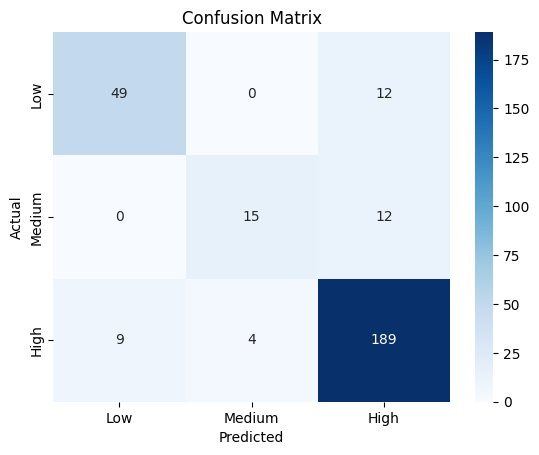

In [22]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle  # For saving the model

# 2. Load Data
df = pd.read_csv('data/processed/cleaned_corr_data.csv')

# 3. Create Price Categories
def price_category(price):
    if price <= 100000:
        return 'Low'
    elif price <= 200000:
        return 'Medium'
    else:
        return 'High'

df['PriceCategory'] = df['SalePrice'].apply(price_category)

# 4. Prepare Features and Target
X = df.drop(columns=['SalePrice', 'PriceCategory'])
y = df['PriceCategory']

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 7. Evaluate the Model
y_pred = model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 8. Save the Model to Disk
with open('models/random_forest_classifier_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Optional: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()